<a href="https://colab.research.google.com/github/victorialovefranklin/Toward-Climate-Resilient-Energy-Systems/blob/main/EAGLEI_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[OK] Loaded 409,920 rows across 10 files (2014–2023).

--- AI Summary ---
Data combines <b>409,920</b> records across <b>2014–2023</b> with <b>9</b> columns. Types: float64×4, object×4, int64×1. Average missingness: <b>22.6%</b>. Numeric features: <b>5</b>; categorical/text: <b>4</b>.
<b>customers_out</b> is highly right-skewed (skew=18.97). Consider log/Box-Cox or robust scaling. <b>sum</b> is highly right-skewed (skew=25.27). Consider log/Box-Cox or robust scaling.

--- Missingness per Column ---


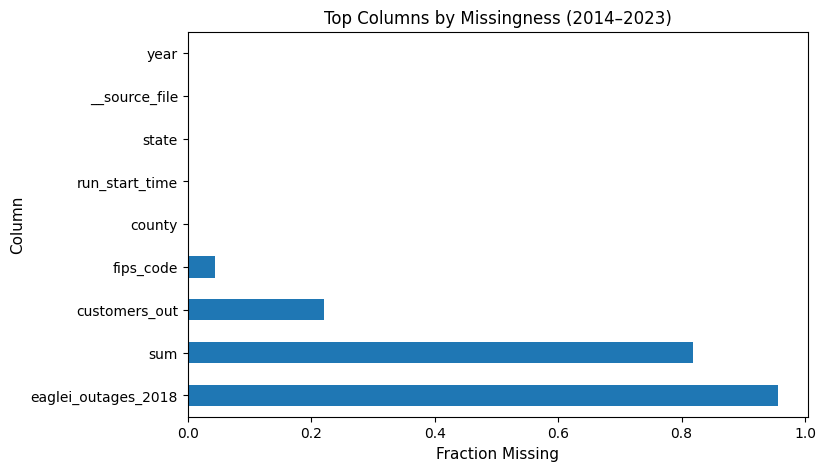


--- Distribution: fips_code ---


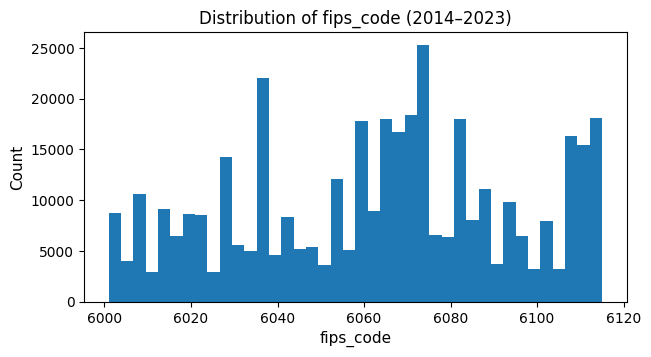


--- Distribution: customers_out ---


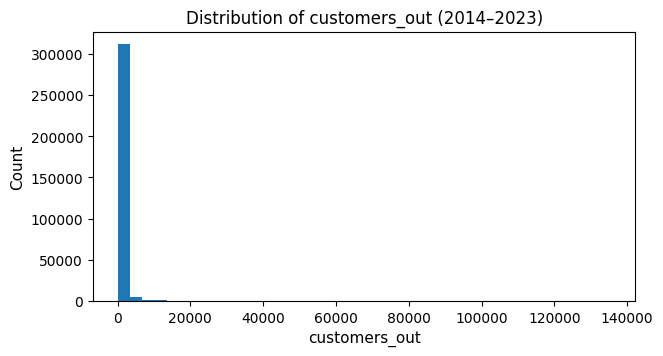


--- Distribution: year ---


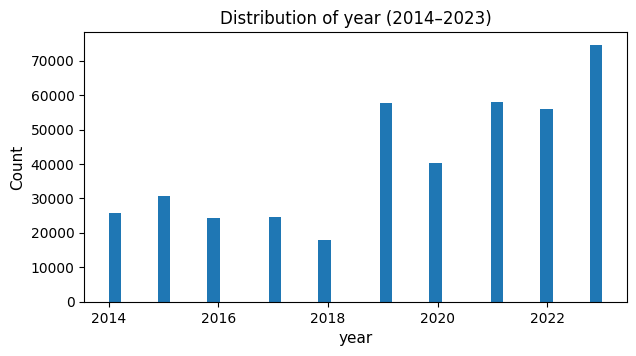


--- Distribution: eaglei_outages_2018 ---


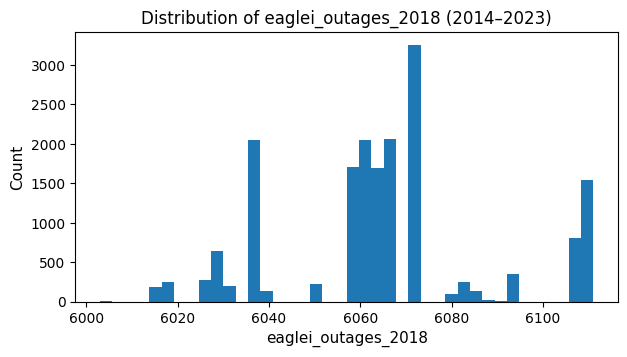


--- Distribution: sum ---


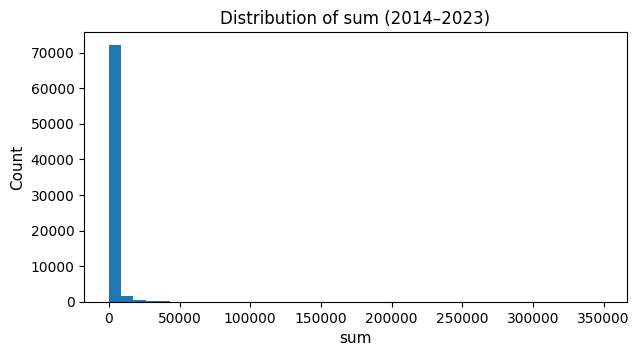


--- Top Values: county ---


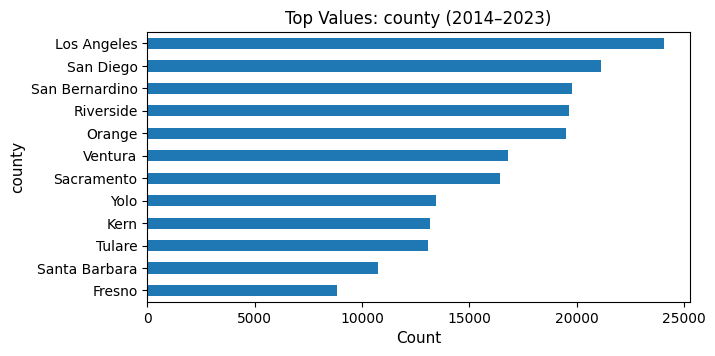


--- Top Values: state ---


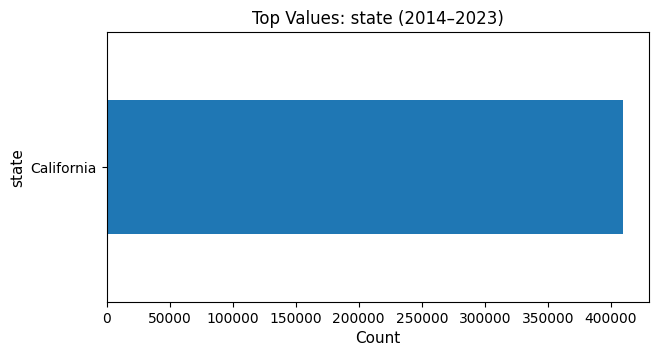


--- Top Values: run_start_time ---


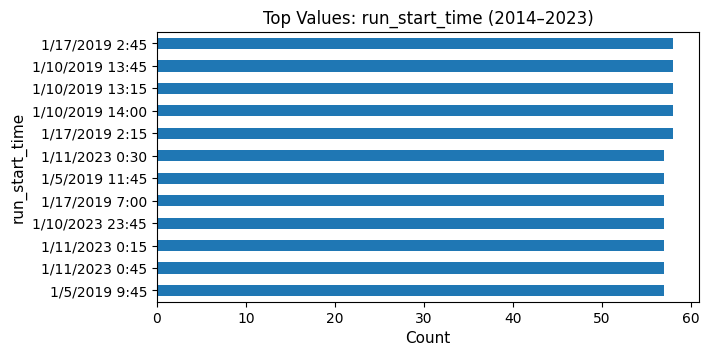


--- Top Values: __source_file ---


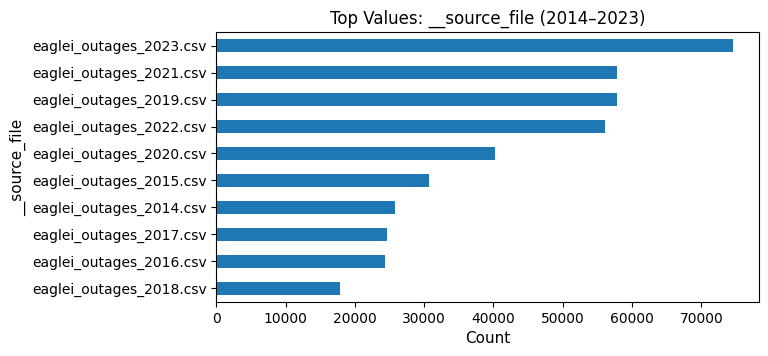


--- Correlation Heatmap ---


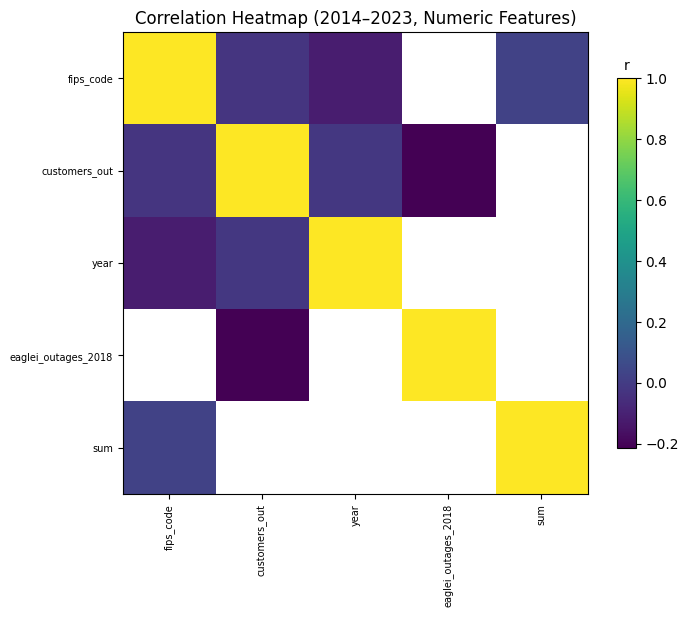


--- Top 15 Counties by Total Customers Out (2014–2023) ---


,fips_code,county,total_customers_out
18,6037.0,Los Angeles,32094152.0
55,6111.0,Ventura,10905070.0
35,6071.0,San Bernardino,10560749.0
36,6073.0,San Diego,8970219.0
29,6059.0,Orange,8800440.0
28,6057.0,Nevada,8384208.0
32,6065.0,Riverside,6762265.0
33,6067.0,Sacramento,6433107.0
8,6017.0,El Dorado,4310417.0
43,6087.0,Santa Cruz,3962331.0



--- Top Counties by Outage Impact ---


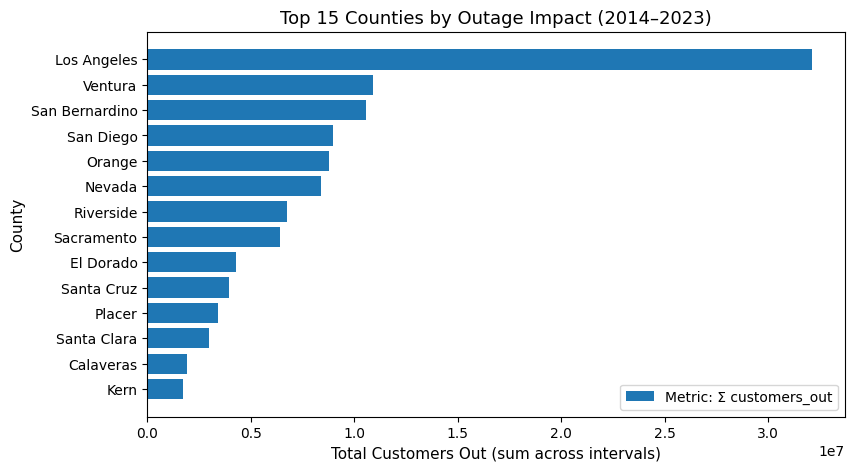


--- Top Counties — Year-over-Year Trends ---


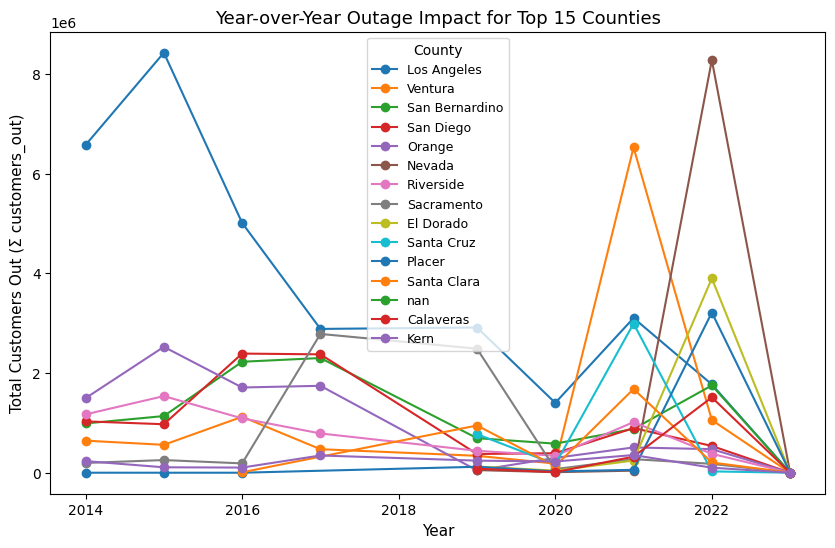


--- Spatial Analysis ---
[WARN] Choropleth failed: '/vsizip/vsicurl/https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_5m.zip' does not exist in the file system, and is not recognized as a supported dataset name.

--- Data Types ---


,column,dtype
fips_code,fips_code,float64
county,county,object
state,state,object
customers_out,customers_out,float64
run_start_time,run_start_time,object
year,year,int64
__source_file,__source_file,object
eaglei_outages_2018,eaglei_outages_2018,float64
sum,sum,float64



--- Missingness Summary (sorted) ---


,column,missing_%
eaglei_outages_2018,eaglei_outages_2018,95.63
sum,sum,81.82
customers_out,customers_out,22.00
fips_code,fips_code,4.37
county,county,0.00
run_start_time,run_start_time,0.00
state,state,0.00
__source_file,__source_file,0.00
year,year,0.00



--- Top Categorical Levels (preview) ---


,column,value,count
0,county,Los Angeles,24061
1,county,San Diego,21119
2,county,San Bernardino,19777
3,county,Riverside,19626
4,county,Orange,19523
5,county,Ventura,16812
6,county,Sacramento,16436
7,county,Yolo,13425
8,county,Kern,13174
9,county,Tulare,13052



--- EDA complete. Results displayed above. ---


In [ ]:
# ===============================================
# EAGLE-I EDA (2014–2023) with Top Counties & Spatial Analysis
# - Loads yearly CSVs from /content/eaglei_outages_2014.csv ... 2023
# - Displays results directly in Colab output
# - Provides AI-style summaries, tables, charts
# - Computes Top Counties by outage impact
# - Maps events: point map (if lat/lon) or county choropleth (if FIPS)
# ===============================================

# ---------- CONFIG ----------
YEAR_RANGE = range(2014, 2024)  # 2014–2023 inclusive
FILE_TEMPLATE = "/content/eaglei_outages_{year}.csv"
# REPORT_HTML = "eda_report.html" # Removed HTML report generation
SEED = 42
SAMPLE_ROWS = 250_000
MAX_PLOTS_PER_SECTION = 12
N_TOP_CATS = 12
TOP_N_COUNTIES = 15
POINT_SAMPLE_FOR_MAP = 50_000  # cap points for plotting

# ---------- IMPORTS ----------
import os, io, sys, base64, warnings, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Optional geopandas (used if available for mapping)
gpd_ok = True
try:
    import geopandas as gpd
    from shapely.geometry import Point
except Exception as e:
    gpd_ok = False
    print(f"[WARN] GeoPandas not available: {e}")

# ---------- LOAD ALL YEARS ----------
frames, missing_files = [], []
for yr in YEAR_RANGE:
    fp = FILE_TEMPLATE.format(year=yr)
    if os.path.exists(fp):
        try:
            df_i = pd.read_csv(fp)
            # add/clean year
            if "year" not in df_i.columns:
                df_i["year"] = yr
            else:
                df_i["year"] = pd.to_numeric(df_i["year"], errors="coerce").fillna(yr).astype(int)
            df_i["__source_file"] = os.path.basename(fp)
            frames.append(df_i)
        except Exception as e:
            print(f"[WARN] Could not load {fp}: {e}")
    else:
        missing_files.append(fp)

if missing_files:
    print("[WARN] Missing files skipped:")
    for m in missing_files:
        print("  -", m)

if not frames:
    raise RuntimeError("No CSVs loaded. Check file paths or names.")

df = pd.concat(frames, ignore_index=True)
df = df[(df["year"] >= 2014) & (df["year"] <= 2023)].copy()
df.drop_duplicates(inplace=True)

print(f"[OK] Loaded {len(df):,} rows across {len(frames)} files (2014–2023).")

# ---------- TRY TO NORMALIZE COMMON COLUMNS ----------
def first_existing(cols):
    return next((c for c in cols if c in df.columns), None)

# candidate columns
customers_cols = ["customers_out", "customers", "cust_out", "customers_outage", "outage_customers"]
fips_cols = ["county_fips", "fips", "fips_code", "county_fips_code"]
county_name_cols = ["county", "county_name"]
lat_cols = ["lat", "latitude", "y", "Lat", "Latitude"]
lon_cols = ["lon", "longitude", "x", "Lon", "Longitude", "long"]

CUSTOMERS_COL = first_existing(customers_cols)
FIPS_COL = first_existing(fips_cols)
COUNTY_NAME_COL = first_existing(county_name_cols)
LAT_COL = first_existing(lat_cols)
LON_COL = first_existing(lon_cols)

# ---------- HELPER: Display Tables and Plots ----------
# Removed HTML embedding functions

def display_table(df_, title, max_rows=100):
    _df = df_.copy()
    if len(_df) > max_rows: _df = _df.head(max_rows)
    print(f"\n--- {title} ---")
    display(_df)

def display_plot(fig, title):
    print(f"\n--- {title} ---")
    plt.show(fig)

def pct(x):
    try: return f"{100*float(x):.1f}%"
    except: return "0.0%"

# ---------- AI-STYLE SUMMARIES ----------
def ai_summary(df_):
    nrows, ncols = df_.shape
    miss_rate = df_.isna().mean().mean()
    dtypes = df_.dtypes.astype(str).value_counts().to_dict()
    num_cols = df_.select_dtypes(include=np.number).columns.tolist()
    cat_cols = df_.select_dtypes(exclude=np.number).columns.tolist()
    span = f"{int(df_['year'].min())}–{int(df_['year'].max())}" if "year" in df_.columns else "2014–2023"
    return (
        f"Data combines <b>{nrows:,}</b> records across <b>{span}</b> with <b>{ncols}</b> columns. "
        f"Types: {', '.join([f'{k}×{v}' for k,v in dtypes.items()])}. "
        f"Average missingness: <b>{pct(miss_rate)}</b>. "
        f"Numeric features: <b>{len(num_cols)}</b>; categorical/text: <b>{len(cat_cols)}</b>."
    )

def ai_notes(df_):
    notes = []
    # skew check
    for c in df_.select_dtypes(include=np.number).columns[:8]:
        s = df_[c].dropna()
        if len(s) < 30: continue
        try:
            sk = float(s.skew())
            if abs(sk) > 1:
                notes.append(f"<b>{c}</b> is highly {'right' if sk>0 else 'left'}-skewed (skew={sk:.2f}). Consider log/Box-Cox or robust scaling.")
        except: pass
    # correlation note
    num = df_.select_dtypes(include=np.number).columns.tolist()
    if len(num) >= 2:
        corr = df_[num].corr(numeric_only=True)
        tri = corr.where(~np.eye(corr.shape[0], dtype=bool))
        tri = tri.unstack().dropna()
        strong = tri[tri.abs() > 0.7].sort_values(key=np.abs, ascending=False)
        if not strong.empty:
            pairs = [f"{a}–{b} (r={strong[(a,b)]:.2f})" for (a,b) in strong.index[:6]]
            notes.append("Potential multicollinearity: " + ", ".join(pairs) + ".")
    return " ".join(notes) if notes else "Distributions appear well-behaved; no severe multicollinearity detected."

# ---------- DISPLAY AI SUMMARIES ----------
print("\n--- AI Summary ---")
print(ai_summary(df))
print(ai_notes(df))

# ---------- CORE SUMMARIES & PLOTS ----------
# Missingness (top 20 columns)
try:
    miss = df.isna().mean().sort_values(ascending=False)
    if miss.sum() > 0:
        fig, ax = plt.subplots(figsize=(8, 5))
        miss.head(20).plot(kind="barh", ax=ax)
        ax.set_title("Top Columns by Missingness (2014–2023)", fontsize=12)
        ax.set_xlabel("Fraction Missing", fontsize=11)
        ax.set_ylabel("Column", fontsize=11)
        display_plot(fig, "Missingness per Column")
except Exception as e:
    print("[WARN] Missingness plot:", e)

# Numeric distributions
num_cols = df.select_dtypes(include=np.number).columns.tolist()
for c in num_cols[:MAX_PLOTS_PER_SECTION]:
    try:
        vals = df[c].dropna().values
        if len(vals) == 0: continue
        fig, ax = plt.subplots(figsize=(7, 3.5))
        ax.hist(vals, bins=40)
        ax.set_title(f"Distribution of {c} (2014–2023)", fontsize=12)
        ax.set_xlabel(c, fontsize=11); ax.set_ylabel("Count", fontsize=11)
        display_plot(fig, f"Distribution: {c}")
    except: pass

# Top categorical frequencies
cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()
for c in cat_cols[:MAX_PLOTS_PER_SECTION]:
    try:
        vc = df[c].astype(str).value_counts().head(N_TOP_CATS)
        if vc.empty: continue
        fig, ax = plt.subplots(figsize=(7, 3.5))
        vc.plot(kind="barh", ax=ax)
        ax.invert_yaxis()
        ax.set_title(f"Top Values: {c} (2014–2023)", fontsize=12)
        ax.set_xlabel("Count", fontsize=11); ax.set_ylabel(c, fontsize=11)
        display_plot(fig, f"Top Values: {c}")
    except: pass

# Correlation heatmap
if len(num_cols) >= 2:
    try:
        corr = df[num_cols].corr(numeric_only=True)
        fig, ax = plt.subplots(figsize=(7.5, 6))
        im = ax.imshow(corr.values, aspect="auto")
        ax.set_xticks(range(len(num_cols))); ax.set_xticklabels(num_cols, rotation=90, fontsize=7)
        ax.set_yticks(range(len(num_cols))); ax.set_yticklabels(num_cols, fontsize=7)
        ax.set_title("Correlation Heatmap (2014–2023, Numeric Features)", fontsize=12)
        cb = fig.colorbar(im, shrink=0.8); cb.ax.set_title("r", fontsize=10)
        display_plot(fig, "Correlation Heatmap")
    except Exception as e:
        print("[WARN] Correlation plot:", e)

# ---------- TOP COUNTIES BY OUTAGE IMPACT ----------
top_tables_html = ""
top_plots = []

def best_customers_col(df_):
    for c in customers_cols:
        if c in df_.columns:
            return c
    return None

CUSTOMERS_COL = CUSTOMERS_COL or best_customers_col(df)

if CUSTOMERS_COL and (FIPS_COL or COUNTY_NAME_COL):
    # aggregate by county across all time (2014–2023)
    group_keys = [c for c in [FIPS_COL, COUNTY_NAME_COL] if c]
    grp = df.groupby(group_keys, dropna=False)[CUSTOMERS_COL].sum().reset_index().sort_values(CUSTOMERS_COL, ascending=False)
    top_counties = grp.head(TOP_N_COUNTIES).copy()

    # table
    display_table(top_counties.rename(columns={CUSTOMERS_COL: "total_customers_out"}), f"Top {TOP_N_COUNTIES} Counties by Total Customers Out (2014–2023)")

    # bar chart (clear header/legend)
    try:
        fig, ax = plt.subplots(figsize=(9, 5))
        label_col = COUNTY_NAME_COL or FIPS_COL
        ax.barh(top_counties[label_col].astype(str), top_counties[CUSTOMERS_COL].values)
        ax.invert_yaxis()
        ax.set_title(f"Top {TOP_N_COUNTIES} Counties by Outage Impact (2014–2023)", fontsize=13)
        ax.set_xlabel("Total Customers Out (sum across intervals)", fontsize=11)
        ax.set_ylabel(label_col.replace("_", " ").title(), fontsize=11)
        # legend-like annotation
        ax.legend([f"Metric: Σ {CUSTOMERS_COL}"], loc="lower right", frameon=True)
        display_plot(fig, "Top Counties by Outage Impact")
    except Exception as e:
        print("[WARN] Top counties plot:", e)

    # year-over-year for top N counties
    try:
        if "year" in df.columns:
            yoy = (
                df[df[group_keys[0]].isin(top_counties[group_keys[0]])]
                .groupby(group_keys + ["year"], dropna=False)[CUSTOMERS_COL]
                .sum()
                .reset_index()
            )
            # Line chart (one line per county)
            fig, ax = plt.subplots(figsize=(10, 6))
            for _, row in (top_counties[[group_keys[0]]].drop_duplicates()).iterrows():
                key_val = row[group_keys[0]]
                sub = yoy[yoy[group_keys[0]] == key_val]
                label = str(key_val)
                if COUNTY_NAME_COL and group_keys[0] == FIPS_COL:
                    # try to map FIPS to county label for nicer legend if available
                    n = grp[grp[FIPS_COL] == key_val][COUNTY_NAME_COL].dropna().astype(str)
                    if not n.empty: label = n.iloc[0]
                ax.plot(sub["year"], sub[CUSTOMERS_COL], marker="o", label=label)
            ax.set_title(f"Year-over-Year Outage Impact for Top {TOP_N_COUNTIES} Counties", fontsize=13)
            ax.set_xlabel("Year", fontsize=11)
            ax.set_ylabel(f"Total Customers Out (Σ {CUSTOMERS_COL})", fontsize=11)
            ax.legend(title="County", fontsize=9)
            display_plot(fig, "Top Counties — Year-over-Year Trends")
    except Exception as e:
        print("[WARN] YoY plot:", e)
else:
    print("\n[INFO] Skipping 'Top Counties' — need a customers/count metric plus county key (FIPS or name).")

# ---------- SPATIAL ANALYSIS ----------
print("\n--- Spatial Analysis ---")
if gpd_ok:
    # CASE A: Points map if lat/lon present
    if LAT_COL and LON_COL:
        try:
            df_pts = df[[LAT_COL, LON_COL]].dropna().copy()
            if len(df_pts) > POINT_SAMPLE_FOR_MAP:
                df_pts = df_pts.sample(POINT_SAMPLE_FOR_MAP, random_state=SEED)
            gdf = gpd.GeoDataFrame(df_pts, geometry=gpd.points_from_xy(df_pts[LON_COL], df_pts[LAT_COL]), crs="EPSG:4326")
            # quick plot
            fig, ax = plt.subplots(figsize=(8, 6))
            gdf.plot(ax=ax, markersize=2, alpha=0.4)
            ax.set_title("Outage Event Points (sampled) — 2014–2023", fontsize=13)
            ax.set_xlabel("Longitude", fontsize=11); ax.set_ylabel("Latitude", fontsize=11)
            display_plot(fig, "Point Map (sampled)")
        except Exception as e:
            print("[WARN] Point mapping failed:", e)
    # CASE B: Choropleth by county using FIPS
    elif FIPS_COL:
        try:
            # Load cartographic county boundaries from US Census (1:5m). If this URL doesn't work in your env, replace with local path.
            # Note: This URL failed in previous execution. If it fails again, replace with a local path to the shapefile.
            counties_url = "https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_5m.zip"
            counties = gpd.read_file(counties_url)  # columns: STATEFP, COUNTYFP, GEOID, NAME, geometry
            counties["GEOID"] = counties["GEOID"].astype(str)
            # build GEOID (FIPS) string in df (pad to 5)
            df_fips = df.copy()
            df_fips[FIPS_COL] = df_fips[FIPS_COL].astype(str).str.zfill(5)
            agg = df_fips.groupby(FIPS_COL)[CUSTOMERS_COL].sum().reset_index() if CUSTOMERS_COL else None
            gdf_counties = counties.merge(agg, how="left", left_on="GEOID", right_on=FIPS_COL) if agg is not None else counties
            # plot choropleth
            fig, ax = plt.subplots(figsize=(10, 6))
            if CUSTOMERS_COL and agg is not None:
                gdf_counties.plot(column=CUSTOMERS_COL, ax=ax, legend=True, legend_kwds={"label": f"Σ {CUSTOMERS_COL} (2014–2023)"},
                                  cmap="viridis", linewidth=0.2, edgecolor="#dddddd", missing_kwds={"color":"#f5f5f5","label":"No data"})
                ax.set_title("County-Level Outage Impact (Choropleth) — 2014–2023", fontsize=13)
            else:
                gdf_counties.plot(ax=ax, color="#cccccc", linewidth=0.2, edgecolor="#dddddd")
                ax.set_title("County-Level Coverage (No metric available)", fontsize=13)
            ax.set_axis_off()
            display_plot(fig, "County Choropleth")
        except Exception as e:
            print(f"[WARN] Choropleth failed: {e}")
    else:
        print("[INFO] No lat/lon or FIPS found; skipping maps.")
else:
    print("[INFO] GeoPandas unavailable; skipping spatial plots.")

# ---------- SNAPSHOT TABLES ----------
dtype_tbl = pd.DataFrame({"column": df.columns, "dtype": df.dtypes.astype(str)})
miss_tbl = (
    pd.DataFrame({"column": df.columns, "missing_%": (df.isna().mean()*100).round(2)})
    .sort_values("missing_%", ascending=False)
)
cat_preview = []
for c in cat_cols[:10] if len(cat_cols:=df.select_dtypes(exclude=np.number).columns.tolist()) else []:
    try:
        vc = df[c].astype(str).value_counts().head(10)
        if len(vc):
            cat_preview.append(pd.DataFrame({"column": c, "value": vc.index, "count": vc.values}))
    except:
        pass
cat_tbl = pd.concat(cat_preview, ignore_index=True) if cat_preview else pd.DataFrame()

print("\n--- Data Types ---")
display(dtype_tbl)
print("\n--- Missingness Summary (sorted) ---")
display(miss_tbl)
if not cat_tbl.empty:
    print("\n--- Top Categorical Levels (preview) ---")
    display(cat_tbl)


# Helpful reminders
if not CUSTOMERS_COL:
    print("\n[NOTE] Could not find a customers/outage metric column. Set CUSTOMERS_COL manually to improve county rankings/choropleth.")
if not (LAT_COL and LON_COL) and not FIPS_COL:
    print("[NOTE] No lat/lon or FIPS detected for mapping. Provide either point coordinates or county FIPS to enable spatial maps.")

print("\n--- EDA complete. Results displayed above. ---")

In [ ]:
# ===============================================
# EAGLE-I EDA (2014–2023) with Top Counties & Spatial Analysis
# - Loads yearly CSVs from /content/eaglei_outages_2014.csv ... 2023
# - Builds eda_report.html with AI-style summaries, tables, charts
# - Computes Top Counties by outage impact
# - Maps events: point map (if lat/lon) or county choropleth (if FIPS)
# ===============================================

# ---------- CONFIG ----------
YEAR_RANGE = range(2014, 2024)  # 2014–2023 inclusive
FILE_TEMPLATE = "/content/eaglei_outages_{year}.csv"
REPORT_HTML = "eda_report.html"
SEED = 42
SAMPLE_ROWS = 250_000
MAX_PLOTS_PER_SECTION = 12
N_TOP_CATS = 12
TOP_N_COUNTIES = 15
POINT_SAMPLE_FOR_MAP = 50_000  # cap points for plotting

# ---------- IMPORTS ----------
import os, io, sys, base64, warnings, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

# Optional geopandas (used if available for mapping)
gpd_ok = True
try:
    import geopandas as gpd
    from shapely.geometry import Point
except Exception as e:
    gpd_ok = False
    print(f"[WARN] GeoPandas not available: {e}")

# ---------- LOAD ALL YEARS ----------
frames, missing_files = [], []
for yr in YEAR_RANGE:
    fp = FILE_TEMPLATE.format(year=yr)
    if os.path.exists(fp):
        try:
            df_i = pd.read_csv(fp)
            # add/clean year
            if "year" not in df_i.columns:
                df_i["year"] = yr
            else:
                df_i["year"] = pd.to_numeric(df_i["year"], errors="coerce").fillna(yr).astype(int)
            df_i["__source_file"] = os.path.basename(fp)
            frames.append(df_i)
        except Exception as e:
            print(f"[WARN] Could not load {fp}: {e}")
    else:
        missing_files.append(fp)

if missing_files:
    print("[WARN] Missing files skipped:")
    for m in missing_files:
        print("  -", m)

if not frames:
    raise RuntimeError("No CSVs loaded. Check file paths or names.")

df = pd.concat(frames, ignore_index=True)
df = df[(df["year"] >= 2014) & (df["year"] <= 2023)].copy()
df.drop_duplicates(inplace=True)

print(f"[OK] Loaded {len(df):,} rows across {len(frames)} files (2014–2023).")

# ---------- TRY TO NORMALIZE COMMON COLUMNS ----------
def first_existing(cols):
    return next((c for c in cols if c in df.columns), None)

# candidate columns
customers_cols = ["customers_out", "customers", "cust_out", "customers_outage", "outage_customers"]
fips_cols = ["county_fips", "fips", "fips_code", "county_fips_code"]
county_name_cols = ["county", "county_name"]
lat_cols = ["lat", "latitude", "y", "Lat", "Latitude"]
lon_cols = ["lon", "longitude", "x", "Lon", "Longitude", "long"]

CUSTOMERS_COL = first_existing(customers_cols)
FIPS_COL = first_existing(fips_cols)
COUNTY_NAME_COL = first_existing(county_name_cols)
LAT_COL = first_existing(lat_cols)
LON_COL = first_existing(lon_cols)

# ---------- HELPER: HTML / PLOT EMBEDS ----------
def to_b64(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format="png", bbox_inches="tight", dpi=140)
    plt.close(fig)
    return base64.b64encode(buf.getvalue()).decode("utf-8")

def html_img(b64, title):
    return f'<figure><img src="data:image/png;base64,{b64}" style="max-width:100%;border:1px solid #eee;border-radius:8px"/><figcaption style="font-size:12px;color:#444;text-align:center;">{title}</figcaption></figure>'

def table_html(df_, title, max_rows=100):
    _df = df_.copy()
    if len(_df) > max_rows: _df = _df.head(max_rows)
    return f"<h3>{title}</h3>{_df.to_html(index=False, border=0, classes='tbl')}"

def pct(x):
    try: return f"{100*float(x):.1f}%"
    except: return "0.0%"

# ---------- AI-STYLE SUMMARIES ----------
def ai_summary(df_):
    nrows, ncols = df_.shape
    miss_rate = df_.isna().mean().mean()
    dtypes = df_.dtypes.astype(str).value_counts().to_dict()
    num_cols = df_.select_dtypes(include=np.number).columns.tolist()
    cat_cols = df_.select_dtypes(exclude=np.number).columns.tolist()
    span = f"{int(df_['year'].min())}–{int(df_['year'].max())}" if "year" in df_.columns else "2014–2023"
    return (
        f"Data combines <b>{nrows:,}</b> records across <b>{span}</b> with <b>{ncols}</b> columns. "
        f"Types: {', '.join([f'{k}×{v}' for k,v in dtypes.items()])}. "
        f"Average missingness: <b>{pct(miss_rate)}</b>. "
        f"Numeric features: <b>{len(num_cols)}</b>; categorical/text: <b>{len(cat_cols)}</b>."
    )

def ai_notes(df_):
    notes = []
    # skew check
    for c in df_.select_dtypes(include=np.number).columns[:8]:
        s = df_[c].dropna()
        if len(s) < 30: continue
        try:
            sk = float(s.skew())
            if abs(sk) > 1:
                notes.append(f"<b>{c}</b> is highly {'right' if sk>0 else 'left'}-skewed (skew={sk:.2f}). Consider log/Box-Cox or robust scaling.")
        except: pass
    # correlation note
    num = df_.select_dtypes(include=np.number).columns.tolist()
    if len(num) >= 2:
        corr = df_[num].corr(numeric_only=True)
        tri = corr.where(~np.eye(corr.shape[0], dtype=bool))
        tri = tri.unstack().dropna()
        strong = tri[tri.abs() > 0.7].sort_values(key=np.abs, ascending=False)
        if not strong.empty:
            pairs = [f"{a}–{b} (r={strong[(a,b)]:.2f})" for (a,b) in strong.index[:6]]
            notes.append("Potential multicollinearity: " + ", ".join(pairs) + ".")
    return " ".join(notes) if notes else "Distributions appear well-behaved; no severe multicollinearity detected."

# ---------- CORE SUMMARIES & PLOTS ----------
plots = []

# Missingness (top 20 columns)
try:
    miss = df.isna().mean().sort_values(ascending=False)
    if miss.sum() > 0:
        fig, ax = plt.subplots(figsize=(8, 5))
        miss.head(20).plot(kind="barh", ax=ax)
        ax.set_title("Top Columns by Missingness (2014–2023)", fontsize=12)
        ax.set_xlabel("Fraction Missing", fontsize=11)
        ax.set_ylabel("Column", fontsize=11)
        plots.append(html_img(to_b64(fig), "Missingness per Column"))
except Exception as e:
    print("[WARN] Missingness plot:", e)

# Numeric distributions
num_cols = df.select_dtypes(include=np.number).columns.tolist()
for c in num_cols[:MAX_PLOTS_PER_SECTION]:
    try:
        vals = df[c].dropna().values
        if len(vals) == 0: continue
        fig, ax = plt.subplots(figsize=(7, 3.5))
        ax.hist(vals, bins=40)
        ax.set_title(f"Distribution of {c} (2014–2023)", fontsize=12)
        ax.set_xlabel(c, fontsize=11); ax.set_ylabel("Count", fontsize=11)
        plots.append(html_img(to_b64(fig), f"Distribution: {c}"))
    except: pass

# Top categorical frequencies
cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()
for c in cat_cols[:MAX_PLOTS_PER_SECTION]:
    try:
        vc = df[c].astype(str).value_counts().head(N_TOP_CATS)
        if vc.empty: continue
        fig, ax = plt.subplots(figsize=(7, 3.5))
        vc.plot(kind="barh", ax=ax)
        ax.invert_yaxis()
        ax.set_title(f"Top Values: {c} (2014–2023)", fontsize=12)
        ax.set_xlabel("Count", fontsize=11); ax.set_ylabel(c, fontsize=11)
        plots.append(html_img(to_b64(fig), f"Top Values: {c}"))
    except: pass

# Correlation heatmap
if len(num_cols) >= 2:
    try:
        corr = df[num_cols].corr(numeric_only=True)
        fig, ax = plt.subplots(figsize=(7.5, 6))
        im = ax.imshow(corr.values, aspect="auto")
        ax.set_xticks(range(len(num_cols))); ax.set_xticklabels(num_cols, rotation=90, fontsize=7)
        ax.set_yticks(range(len(num_cols))); ax.set_yticklabels(num_cols, fontsize=7)
        ax.set_title("Correlation Heatmap (2014–2023, Numeric Features)", fontsize=12)
        cb = fig.colorbar(im, shrink=0.8); cb.ax.set_title("r", fontsize=10)
        plots.append(html_img(to_b64(fig), "Correlation Heatmap"))
    except Exception as e:
        print("[WARN] Correlation plot:", e)

# ---------- TOP COUNTIES BY OUTAGE IMPACT ----------
top_tables_html = ""
top_plots = []

def best_customers_col(df_):
    for c in customers_cols:
        if c in df_.columns:
            return c
    return None

CUSTOMERS_COL = CUSTOMERS_COL or best_customers_col(df)

if CUSTOMERS_COL and (FIPS_COL or COUNTY_NAME_COL):
    # aggregate by county across all time (2014–2023)
    group_keys = [c for c in [FIPS_COL, COUNTY_NAME_COL] if c]
    grp = df.groupby(group_keys, dropna=False)[CUSTOMERS_COL].sum().reset_index().sort_values(CUSTOMERS_COL, ascending=False)
    top_counties = grp.head(TOP_N_COUNTIES).copy()

    # table
    top_tables_html += table_html(top_counties.rename(columns={CUSTOMERS_COL: "total_customers_out"}), f"Top {TOP_N_COUNTIES} Counties by Total Customers Out (2014–2023)")

    # bar chart (clear header/legend)
    try:
        fig, ax = plt.subplots(figsize=(9, 5))
        label_col = COUNTY_NAME_COL or FIPS_COL
        ax.barh(top_counties[label_col].astype(str), top_counties[CUSTOMERS_COL].values)
        ax.invert_yaxis()
        ax.set_title(f"Top {TOP_N_COUNTIES} Counties by Outage Impact (2014–2023)", fontsize=13)
        ax.set_xlabel("Total Customers Out (sum across intervals)", fontsize=11)
        ax.set_ylabel(label_col.replace("_", " ").title(), fontsize=11)
        # legend-like annotation
        ax.legend([f"Metric: Σ {CUSTOMERS_COL}"], loc="lower right", frameon=True)
        top_plots.append(html_img(to_b64(fig), "Top Counties by Outage Impact"))
    except Exception as e:
        print("[WARN] Top counties plot:", e)

    # year-over-year for top N counties
    try:
        if "year" in df.columns:
            yoy = (
                df[df[group_keys[0]].isin(top_counties[group_keys[0]])]
                .groupby(group_keys + ["year"], dropna=False)[CUSTOMERS_COL]
                .sum()
                .reset_index()
            )
            # Line chart (one line per county)
            fig, ax = plt.subplots(figsize=(10, 6))
            for _, row in (top_counties[[group_keys[0]]].drop_duplicates()).iterrows():
                key_val = row[group_keys[0]]
                sub = yoy[yoy[group_keys[0]] == key_val]
                label = str(key_val)
                if COUNTY_NAME_COL and group_keys[0] == FIPS_COL:
                    # try to map FIPS to county label for nicer legend if available
                    n = grp[grp[FIPS_COL] == key_val][COUNTY_NAME_COL].dropna().astype(str)
                    if not n.empty: label = n.iloc[0]
                ax.plot(sub["year"], sub[CUSTOMERS_COL], marker="o", label=label)
            ax.set_title(f"Year-over-Year Outage Impact for Top {TOP_N_COUNTIES} Counties", fontsize=13)
            ax.set_xlabel("Year", fontsize=11)
            ax.set_ylabel(f"Total Customers Out (Σ {CUSTOMERS_COL})", fontsize=11)
            ax.legend(title="County", fontsize=9)
            top_plots.append(html_img(to_b64(fig), "Top Counties — Year-over-Year Trends"))
    except Exception as e:
        print("[WARN] YoY plot:", e)
else:
    print("[INFO] Skipping 'Top Counties' — need a customers/count metric plus county key (FIPS or name).")

# ---------- SPATIAL ANALYSIS ----------
map_html = ""
if gpd_ok:
    # CASE A: Points map if lat/lon present
    if LAT_COL and LON_COL:
        try:
            df_pts = df[[LAT_COL, LON_COL]].dropna().copy()
            if len(df_pts) > POINT_SAMPLE_FOR_MAP:
                df_pts = df_pts.sample(POINT_SAMPLE_FOR_MAP, random_state=SEED)
            gdf = gpd.GeoDataFrame(df_pts, geometry=gpd.points_from_xy(df_pts[LON_COL], df_pts[LAT_COL]), crs="EPSG:4326")
            # quick plot
            fig, ax = plt.subplots(figsize=(8, 6))
            gdf.plot(ax=ax, markersize=2, alpha=0.4)
            ax.set_title("Outage Event Points (sampled) — 2014–2023", fontsize=13)
            ax.set_xlabel("Longitude", fontsize=11); ax.set_ylabel("Latitude", fontsize=11)
            map_html += html_img(to_b64(fig), "Point Map (sampled)")
        except Exception as e:
            print("[WARN] Point mapping failed:", e)
    # CASE B: Choropleth by county using FIPS
    elif FIPS_COL:
        try:
            # Load cartographic county boundaries from US Census (1:5m). If this URL doesn't work in your env, replace with local path.
            counties_url = "https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_5m.zip"
            counties = gpd.read_file(counties_url)  # columns: STATEFP, COUNTYFP, GEOID, NAME, geometry
            counties["GEOID"] = counties["GEOID"].astype(str)
            # build GEOID (FIPS) string in df (pad to 5)
            df_fips = df.copy()
            df_fips[FIPS_COL] = df_fips[FIPS_COL].astype(str).str.zfill(5)
            agg = df_fips.groupby(FIPS_COL)[CUSTOMERS_COL].sum().reset_index() if CUSTOMERS_COL else None
            gdf_counties = counties.merge(agg, how="left", left_on="GEOID", right_on=FIPS_COL) if agg is not None else counties
            # plot choropleth
            fig, ax = plt.subplots(figsize=(10, 6))
            if CUSTOMERS_COL and agg is not None:
                gdf_counties.plot(column=CUSTOMERS_COL, ax=ax, legend=True, legend_kwds={"label": f"Σ {CUSTOMERS_COL} (2014–2023)"},
                                  cmap="viridis", linewidth=0.2, edgecolor="#dddddd", missing_kwds={"color":"#f5f5f5","label":"No data"})
                ax.set_title("County-Level Outage Impact (Choropleth) — 2014–2023", fontsize=13)
            else:
                gdf_counties.plot(ax=ax, color="#cccccc", linewidth=0.2, edgecolor="#dddddd")
                ax.set_title("County-Level Coverage (No metric available)", fontsize=13)
            ax.set_axis_off()
            map_html += html_img(to_b64(fig), "County Choropleth")
        except Exception as e:
            print("[WARN] Choropleth failed:", e)
    else:
        print("[INFO] No lat/lon or FIPS found; skipping maps.")
else:
    print("[INFO] GeoPandas unavailable; skipping spatial plots.")

# ---------- SNAPSHOT TABLES ----------
dtype_tbl = pd.DataFrame({"column": df.columns, "dtype": df.dtypes.astype(str)})
miss_tbl = (
    pd.DataFrame({"column": df.columns, "missing_%": (df.isna().mean()*100).round(2)})
    .sort_values("missing_%", ascending=False)
)
cat_preview = []
for c in cat_cols[:10] if len(cat_cols:=df.select_dtypes(exclude=np.number).columns.tolist()) else []:
    try:
        vc = df[c].astype(str).value_counts().head(10)
        if len(vc):
            cat_preview.append(pd.DataFrame({"column": c, "value": vc.index, "count": vc.values}))
    except:
        pass
cat_tbl = pd.concat(cat_preview, ignore_index=True) if cat_preview else pd.DataFrame()

# ---------- BUILD HTML ----------
STYLE = """
<style>
body { font-family: -apple-system, Segoe UI, Roboto, Helvetica, Arial, sans-serif; color:#222; }
h1,h2,h3 { margin-top: 1rem; }
.tbl { border-collapse: collapse; width:100%; font-size: 13px; }
.tbl th,.tbl td { border:1px solid #eee; padding:6px 8px; text-align:left; }
figcaption { font-size:12px; color:#555; text-align:center; }
.section-note { color:#444; font-size:13px; background:#fafafa; border:1px solid #eee; padding:10px; border-radius:8px; }
</style>
"""

parts = []
parts.append("<h1>EAGLE-I (2014–2023) Exploratory Data Analysis</h1>")
parts.append(f"<p class='section-note'><b>AI Summary:</b> {ai_summary(df)}<br>{ai_notes(df)}</p>")
parts.append(table_html(dtype_tbl, "Data Types"))
parts.append(table_html(miss_tbl, "Missingness Summary (sorted)"))
if not cat_tbl.empty:
    parts.append(table_html(cat_tbl, "Top Categorical Levels (preview)"))
parts.append("<h2>Core Visualizations</h2>" + "".join(plots))

# Top counties section
if top_tables_html or top_plots:
    parts.append("<h2>Top Counties by Outage Impact</h2>")
    if top_tables_html:
        parts.append(top_tables_html)
    if top_plots:
        parts.append("".join(top_plots))

# Spatial section
if map_html:
    parts.append("<h2>Spatial Analysis</h2>")
    parts.append(map_html)

parts.append(f"<footer><small>Generated • Rows: {len(df):,} • Cols: {df.shape[1]} • Years: 2014–2023</small></footer>")

with open(REPORT_HTML, "w", encoding="utf-8") as f:
    f.write(f"<html><head><meta charset='utf-8'>{STYLE}</head><body>")
    f.write("\n".join(parts))
    f.write("</body></html>")

print(f"[OK] EDA report generated: {os.path.abspath(REPORT_HTML)}")

# Helpful reminders
if not CUSTOMERS_COL:
    print("[NOTE] Could not find a customers/outage metric column. Set CUSTOMERS_COL manually to improve county rankings/choropleth.")
if not (LAT_COL and LON_COL) and not FIPS_COL:
    print("[NOTE] No lat/lon or FIPS detected for mapping. Provide either point coordinates or county FIPS to enable spatial maps.")


[OK] Loaded 409,920 rows across 10 files (2014–2023).
[WARN] Choropleth failed: '/vsizip/vsicurl/https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_5m.zip' does not exist in the file system, and is not recognized as a supported dataset name.
[OK] EDA report generated: /content/eda_report.html
